# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil


import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
#from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [4]:
model_name = "mono+stereo_640x192"
model_path="/home/ubuntu/data/models_monodepth2/"

#download_model_if_doesnt_exist(model_name)
encoder_path = model_path+ model_name+"/encoder.pth"
depth_decoder_path = model_path+ model_name+"/depth.pth"

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [5]:
image_path = "assets/kou1.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [6]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

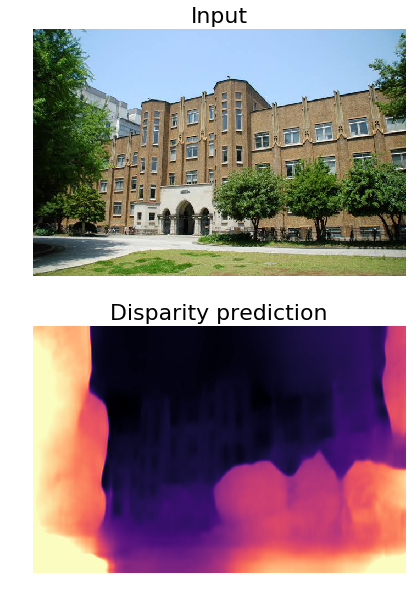

In [7]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [8]:
1/disp_resized_np

array([[18.351528 , 18.482264 , 18.549063 , ..., 26.013655 , 25.953182 ,
        25.909685 ],
       [18.34884  , 18.483494 , 18.552141 , ..., 26.022993 , 25.964684 ,
        25.920094 ],
       [18.340588 , 18.487278 , 18.561611 , ..., 26.051723 , 26.000076 ,
        25.952118 ],
       ...,
       [ 9.471188 ,  9.414396 ,  9.40343  , ..., 13.6618805, 13.631577 ,
        13.635047 ],
       [ 9.445135 ,  9.385223 ,  9.378182 , ..., 13.617292 , 13.586271 ,
        13.587493 ],
       [ 9.436686 ,  9.375766 ,  9.369993 , ..., 13.60284  , 13.571589 ,
        13.572085 ]], dtype=float32)

In [9]:
disp_resized_np

array([[0.05449137, 0.05410593, 0.05391108, ..., 0.03844135, 0.03853092,
        0.03859561],
       [0.05449936, 0.05410232, 0.05390213, ..., 0.03842755, 0.03851385,
        0.03858011],
       [0.05452388, 0.05409125, 0.05387463, ..., 0.03838518, 0.03846142,
        0.0385325 ],
       ...,
       [0.10558338, 0.1062203 , 0.10634418, ..., 0.07319637, 0.07335909,
        0.07334042],
       [0.10587461, 0.10655047, 0.10663047, ..., 0.07343604, 0.07360371,
        0.0735971 ],
       [0.10596941, 0.10665795, 0.10672367, ..., 0.07351406, 0.07368334,
        0.07368065]], dtype=float32)

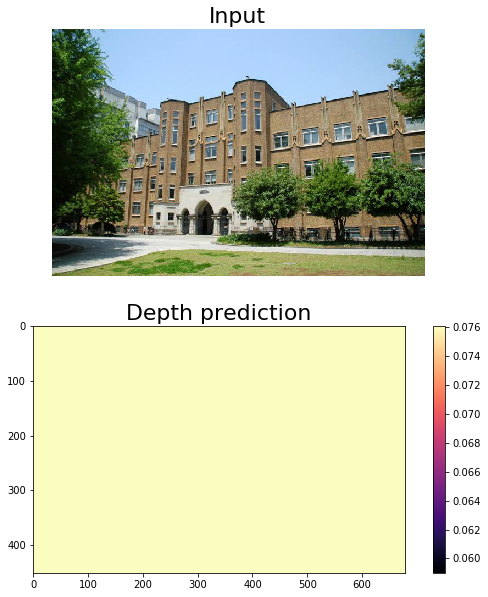

In [10]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow((1/disp_resized_np)/np.max(1/disp_resized_np), cmap='magma', vmax=vmax)
plt.title("Depth prediction", fontsize=22)
plt.colorbar()
plt.axis('on');


In [11]:
np.max(1/disp_resized_np)

112.97901

In [12]:
np.min(1/disp_resized_np)

8.594235

In [13]:
depth=1/disp_resized_np

In [14]:
np.unravel_index(np.argmax(depth),depth.shape)

(141, 168)